In [1]:
import os
import glob
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.functional as F


In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [3]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=20, verbose=False, delta= -0.00001):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score - self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                print(f"Early Stopping activated. Final validation loss : {self.val_loss_min:.7f}")
                self.early_stop = True
        # if the current score does not exceed the best scroe, run the codes following below
        else:  
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), './checkpoint.pt')
        self.val_loss_min = val_loss

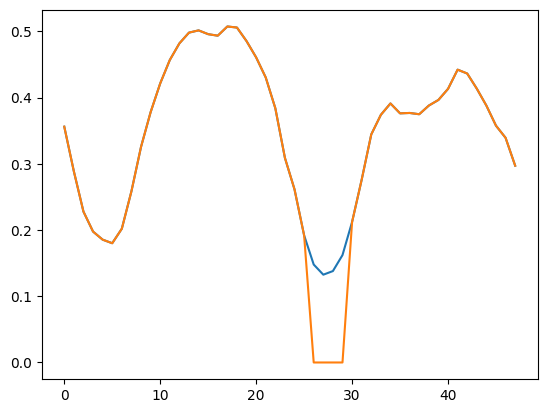

In [70]:
class TS_Dataset(torch.utils.data.Dataset):

    def __init__(self, root_dir, mask_data=True, len_mask=4):
        super().__init__()
        self.root_dir = root_dir
        self.data = self.load_data()
        self.mask_data = mask_data
        self.len_mask = len_mask

    def __getitem__(self, idx):
        ts = np.load(self.data[idx])
        ts = torch.tensor(ts, dtype=torch.float)#.squeeze(1)
        if self.mask_data:
            mask = torch.ones_like(ts)
            mask_idx = random.randint(0, len(ts) - self.len_mask-1)
            mask[mask_idx:mask_idx+self.len_mask] = 0
            masked_ts = ts * mask
            return {
                "clean_data": ts.unsqueeze(-1),
                "masked_data": masked_ts.unsqueeze(-1),
                "mask": mask.unsqueeze(-1)
            }
        else:
            pass

    def __len__(self):
        return len(self.data)

    def load_data(self):
        data = glob.glob(os.path.join(self.root_dir, "data", "*.npy"))
        return data


train_dataset = TS_Dataset("../../dataset/processed/AEMO/test/ad_train_contam")
plt.plot(train_dataset.__getitem__(0)["clean_data"])
plt.plot(train_dataset.__getitem__(0)["masked_data"])

In [71]:
dataset_root = "../../dataset/processed/AEMO/test/ad_train_contam"
train_dataset = TS_Dataset(dataset_root)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=False,
    pin_memory=True,
)

test_dataset = TS_Dataset(dataset_root)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    pin_memory=True,
)

In [72]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
# from .early_stopping import *
from tqdm import tqdm_notebook as tqdm

torch.manual_seed(0)

# (1) Encoder
class Encoder(nn.Module):
    def __init__(self, seq_len, no_features, embedding_size):
        super().__init__()
        
        self.seq_len = seq_len
        self.no_features = no_features    # The number of expected features(= dimension size) in the input x
        self.embedding_size = embedding_size   # the number of features in the embedded points of the inputs' number of features
        self.hidden_size = (2 * embedding_size)  # The number of features in the hidden state h
        self.LSTM1 = nn.LSTM(
            input_size = no_features,
            hidden_size = embedding_size,
            num_layers = 1,
            batch_first=True
        )
        
    def forward(self, x):
        # Inputs: input, (h_0, c_0). -> If (h_0, c_0) is not provided, both h_0 and c_0 default to zero.
        x, (hidden_state, cell_state) = self.LSTM1(x)  
        last_lstm_layer_hidden_state = hidden_state[-1,:,:]
        return last_lstm_layer_hidden_state
    
    
# (2) Decoder
class Decoder(nn.Module):
    def __init__(self, seq_len, no_features, output_size):
        super().__init__()

        self.seq_len = seq_len
        self.no_features = no_features
        self.hidden_size = (2 * no_features)
        self.output_size = output_size
        self.LSTM1 = nn.LSTM(
            input_size = no_features,
            hidden_size = self.hidden_size,
            num_layers = 1,
            batch_first = True
        )

        self.fc = nn.Linear(self.hidden_size, output_size)
        
    def forward(self, x):
        x = x.unsqueeze(1).repeat(1, self.seq_len, 1)
        x, (hidden_state, cell_state) = self.LSTM1(x)
        x = x.reshape((-1, self.seq_len, self.hidden_size))
        out = self.fc(x)
        return out
    
# (3) Autoencoder : putting the encoder and decoder together
class LSTM_AE(nn.Module):
    """
    Parameters
        input_sequences: A list (or tensor) of shape [num_seqs, seq_len, num_features] representing your training set of sequences.
            Each sequence should have the same length, seq_len, and contain a sequence of vectors of size num_features.
            If num_features=1, then you can input a list of shape [num_seqs, seq_len] instead.
            [Notice] Currently TorchCoder can take [num_seqs, seq_len] as an input. Soon to be fixed.
        embedding_dim: Size of the vector encodings you want to create.
        learning_rate: Learning rate for the autoencoder. default = 1e-3
        every_epoch_print : Deciding the size of N to print the loss every N epochs. default = 100
        epochs: Total number of epochs to train for. default = 10000
        patience : Number of epochs to wait for if the loss does not decrease. default = 20
        max_grad_norm : Maximum size for gradient used in gradient descent (gradient clipping). default = 0.005

    Returns
        encoded: The encoded vector (representation) of the input_sequences.
        decoded: The decoded vector of encoded, which should be very close to the input_sequences.
        final_loss: The final mean squared error of the autoencoder on the training set.

    """
    def __init__(self, seq_len, no_features, embedding_dim, learning_rate=1e-3, every_epoch_print=100, epochs=10000, patience=20, max_grad_norm=0.005):
        super().__init__()
        
        self.seq_len = seq_len
        self.no_features = no_features
        self.embedding_dim = embedding_dim

        self.encoder = Encoder(self.seq_len, self.no_features, self.embedding_dim).to(device)
        self.decoder = Decoder(self.seq_len, self.embedding_dim, self.no_features).to(device)
        self.criterion = nn.MSELoss(reduction='mean')
        
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.patience = patience
        self.max_grad_norm = max_grad_norm
        self.every_epoch_print = every_epoch_print
    
    def forward(self, x):
        torch.manual_seed(0)
        encoded = self.encoder(x.to(device))
        decoded = self.decoder(encoded)
        return encoded, decoded
    
    def fit(self, train_loader):
        """
        trains the model's parameters over a fixed number of epochs, specified by `n_epochs`, as long as the loss keeps decreasing.
        :param dataset: `Dataset` object
        :param bool save: If true, dumps the trained model parameters as pickle file at `dload` directory
        :return:
        """
        optimizer = torch.optim.Adam(self.parameters(), lr = self.learning_rate)
        self.train()
        # initialize the early_stopping object
        early_stopping = EarlyStopping(patience=self.patience, verbose=False)
        loss_history = []

        for epoch in range(1 , self.epochs+1):
            # updating early_stopping's epoch
            early_stopping.epoch = epoch    
            epoch_loss = 0.0
            
            for batch_idx, batch in enumerate(train_loader):
                clean_ts = batch["clean_data"].to(device)
                masked_ts = batch["masked_data"].to(device)
                mask = batch["mask"].to(device)
                optimizer.zero_grad()
                encoded, decoded = self(masked_ts)

                # running_loss = self.criterion(clean_ts , decoded)
                # loss is difference between clean_ts and decoded for the masked_ts
                running_loss = self.criterion(clean_ts * mask, decoded * mask)
                
                epoch_loss += running_loss.item()
                # Backward pass
                running_loss.backward()
                nn.utils.clip_grad_norm_(self.parameters(), max_norm = self.max_grad_norm) # clipping avoids exploding gradients
                optimizer.step()
            
            # early_stopping needs the validation loss to check if it has decresed, 
            # and if it has, it will make a checkpoint of the current model
            early_stopping(epoch_loss, self)

            if early_stopping.early_stop:
                break
            
            if epoch % self.every_epoch_print == 0:
                print(f"epoch : {epoch}, loss_mean : {epoch_loss:.7f}")

            loss_history.append(epoch_loss)
        
        # load the last checkpoint with the best model (saved by EarlyStopping)
        self.load_state_dict(torch.load('./checkpoint.pt'))

        return loss_history
    
    def load(self, PATH='./checkpoint.pt'):
        """
        Loads the model's parameters from the path mentioned
        :param PATH: Should contain pickle file
        :return: None
        """
        self.is_fitted = True
        self.load_state_dict(torch.load(PATH))


    def infer(self, data):
        self.eval()
        data = data.to(device)
        encoded, decoded = self(data)
        return decoded

epoch : 1, loss_mean : 1.4876569
epoch : 2, loss_mean : 0.6276411
epoch : 3, loss_mean : 0.5822931
epoch : 4, loss_mean : 0.4962832
epoch : 5, loss_mean : 0.4740537
epoch : 6, loss_mean : 0.4666881
epoch : 7, loss_mean : 0.5254087
epoch : 8, loss_mean : 0.3945004
epoch : 9, loss_mean : 0.4136306
epoch : 10, loss_mean : 0.4488489
epoch : 11, loss_mean : 0.3942871
epoch : 12, loss_mean : 0.2980500
epoch : 13, loss_mean : 0.2959832
epoch : 14, loss_mean : 0.2502285
epoch : 15, loss_mean : 0.2469199
epoch : 16, loss_mean : 0.2814282
epoch : 17, loss_mean : 0.2182203
epoch : 18, loss_mean : 0.3829692
epoch : 19, loss_mean : 0.3351255
epoch : 20, loss_mean : 0.2161247
epoch : 21, loss_mean : 0.2215136
epoch : 22, loss_mean : 0.2035562
epoch : 23, loss_mean : 0.1931241
epoch : 24, loss_mean : 0.1984684
epoch : 25, loss_mean : 0.1848626
epoch : 26, loss_mean : 0.2217536
epoch : 27, loss_mean : 0.2064764
epoch : 28, loss_mean : 0.1829175
epoch : 29, loss_mean : 0.2037526
epoch : 30, loss_mean :

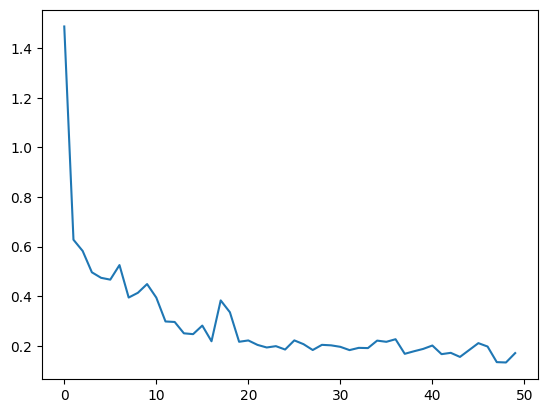

In [73]:
seq_len = 48
no_features = 1
embedding_dim = 128
learning_rate = 1e-3
every_epoch_print = 1
epochs = 50
patience = 20
max_grad_norm = 0.05

model = LSTM_AE(seq_len, no_features, embedding_dim, learning_rate, every_epoch_print, epochs, patience, max_grad_norm)
loss_history = model.fit(train_dataloader)

plt.plot(loss_history)

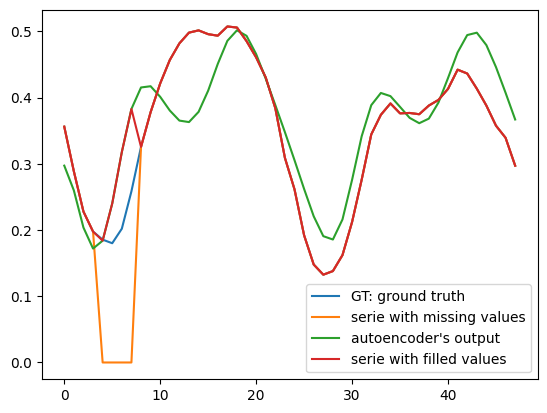

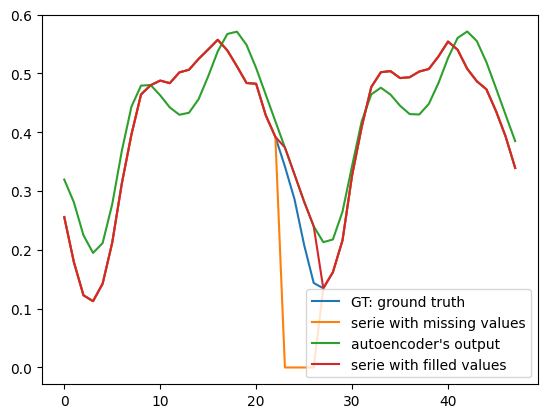

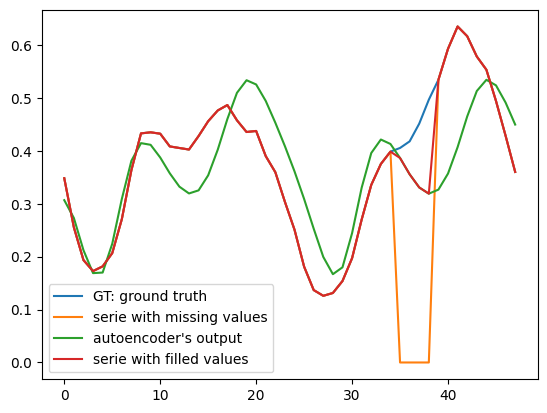

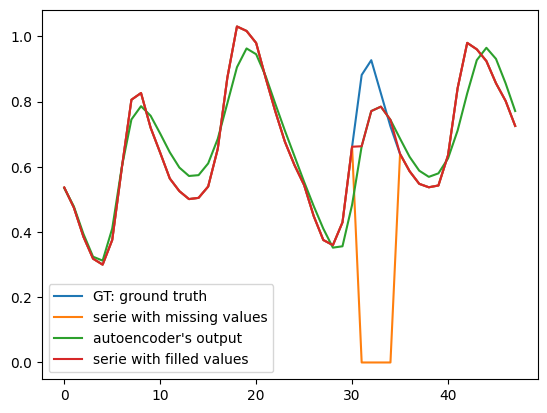

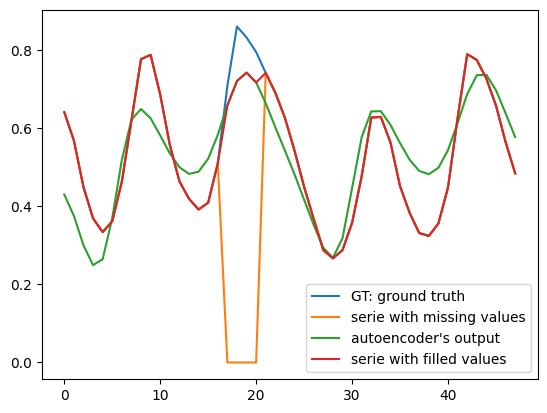

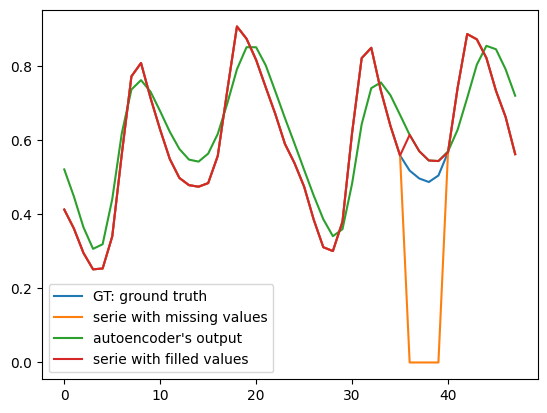

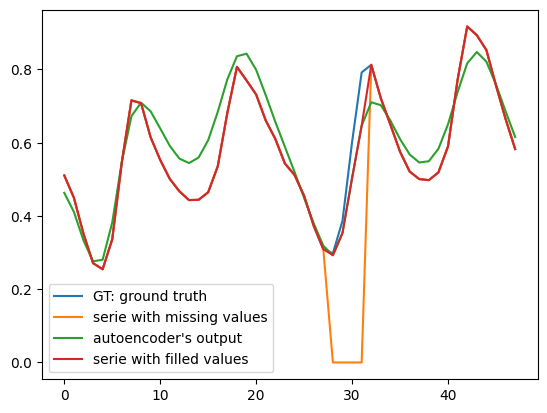

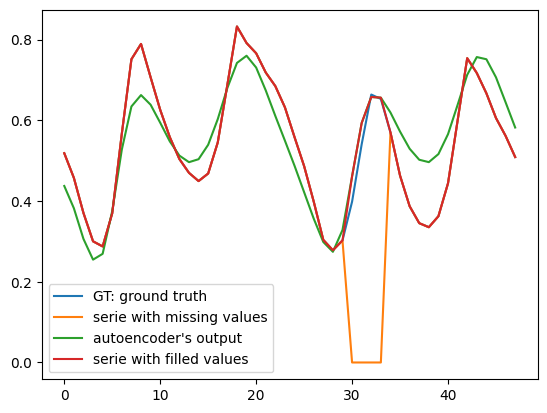

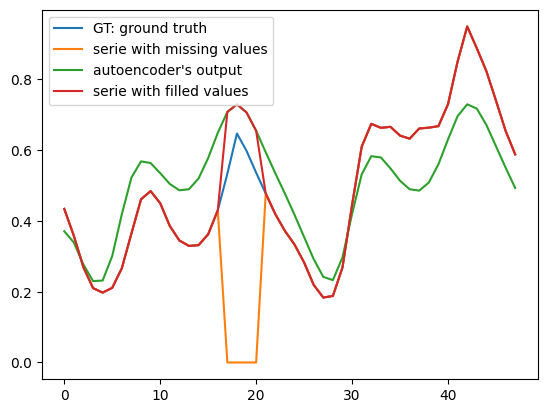

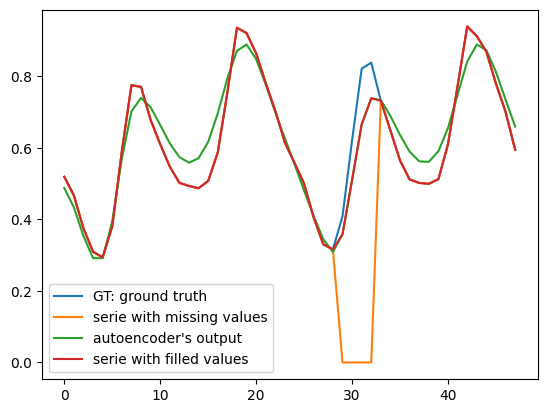

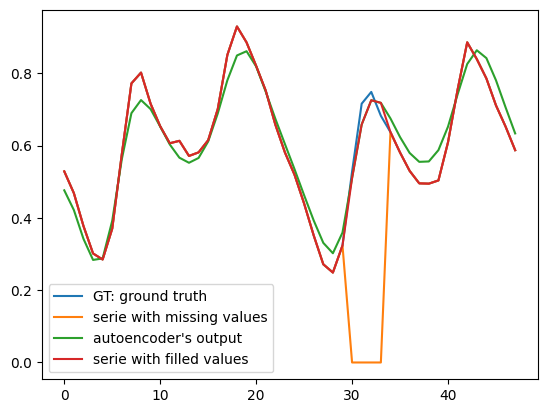

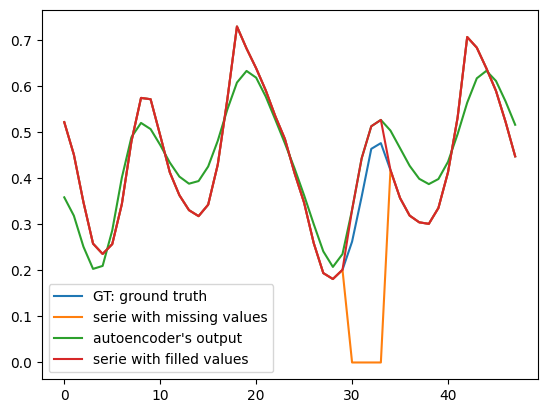

<Figure size 640x480 with 0 Axes>

In [90]:
loaded_model = LSTM_AE(seq_len, no_features, embedding_dim, learning_rate, every_epoch_print, epochs, patience, max_grad_norm)
loaded_model.load()

for i, batch in enumerate(test_dataloader):
    ts = batch["masked_data"]
    mask = batch["mask"]
    gt_ts = batch["clean_data"]

    model_out = loaded_model.infer(ts)
    model_out = model_out.squeeze(0).squeeze(-1).detach().cpu()#.numpy()
    filled_ts = ts.clone().squeeze(0).squeeze(-1).detach().cpu()#.numpy()
    mask = mask.squeeze(0).squeeze(-1).detach().cpu()#.numpy()
    filled_ts[mask==0] = model_out[mask==0]
    gt_ts = gt_ts.squeeze(0).squeeze(-1).detach().cpu()#.numpy()

    plt.plot(gt_ts, label="GT: ground truth")
    plt.plot(ts.squeeze(0).squeeze(-1), label="serie with missing values")
    plt.plot(model_out, label="autoencoder's output")
    plt.plot(filled_ts.squeeze(0).squeeze(-1), label="serie with filled values")
    plt.legend()
    plt.show()
    plt.clf()
    if i > 10:    break